In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

import keras as K
from keras_contrib.layers.normalization import BatchRenormalization

MAIN_DIR = '/home/saint/experiments/sdcnd/'
DATA_DIR = MAIN_DIR + 'train_sim/'

Using TensorFlow backend.


In [2]:
import cv2
import pandas as pd
    
colnames  = ['center', 'left', 'right', 'angle', 'throttle', 'brake', 'speed']
ds = pd.read_csv(DATA_DIR + 'driving_log.csv', skiprows=[0], names=colnames)

center_paths  = ds.center.tolist()
left_paths    = ds.left.tolist()
right_paths   = ds.right.tolist()
center_angles = ds.angle.tolist()

center_imgs = []
left_imgs   = []
right_imgs  = []

def bgr2rgbAppend(img_path, result_images):
    bgr = cv2.imread(img_path)
    result_images.append(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

for img_path in center_paths:
    bgr2rgbAppend(img_path, center_imgs)

for img_path in left_paths:
    bgr2rgbAppend(img_path, left_imgs)
    
for img_path in right_paths:
    bgr2rgbAppend(img_path, right_imgs)

In [3]:
import numpy as np

def list_shape(imgs):
    return np.shape(imgs)

print("Shape of center images =", list_shape(center_imgs))
print("Shape of left images   =", list_shape(left_imgs))
print("Shape of right images  =", list_shape(right_imgs))
print("Shape of angles        =", list_shape(center_angles))
print("Mean, std, min-max of angles: ", np.mean(center_angles),
                                        np.std(center_angles),
                                        np.min(center_angles),
                                        np.max(center_angles))

Shape of center images = (6302, 160, 320, 3)
Shape of left images   = (6302, 160, 320, 3)
Shape of right images  = (6302, 160, 320, 3)
Shape of angles        = (6302,)
Mean, std, min-max of angles:  0.000627119719137 0.136017018326 -0.8721392 1.0


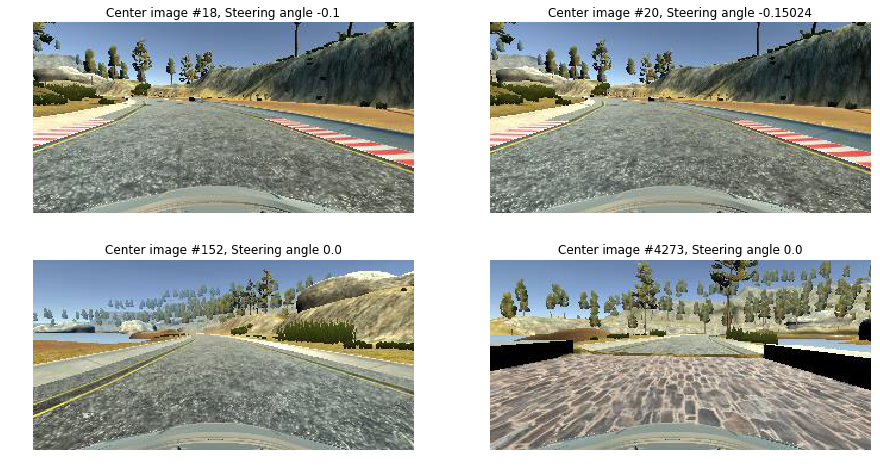

In [4]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig, axs = plt.subplots(2,2, figsize=(15, 8))
axs = axs.ravel()
lim = 4
# Show 2 random images with steering angles > 0 and two random
for index,img in enumerate(center_imgs):
    if lim == 0:
        break
    elif lim > 2:
        if center_angles[index] < 0.01 and center_angles[index] > -0.01:
            continue
        elif random.random() > 0.2:
            continue
    else:
        index = random.randint(0, len(center_imgs))

    image = center_imgs[index]
    axs[4 - lim].axis('off')
    axs[4 - lim].imshow(image)
    axs[4 - lim].set_title('Center image #{}, Steering angle {}'.format(str(index), str(center_angles[index])))
    lim -= 1

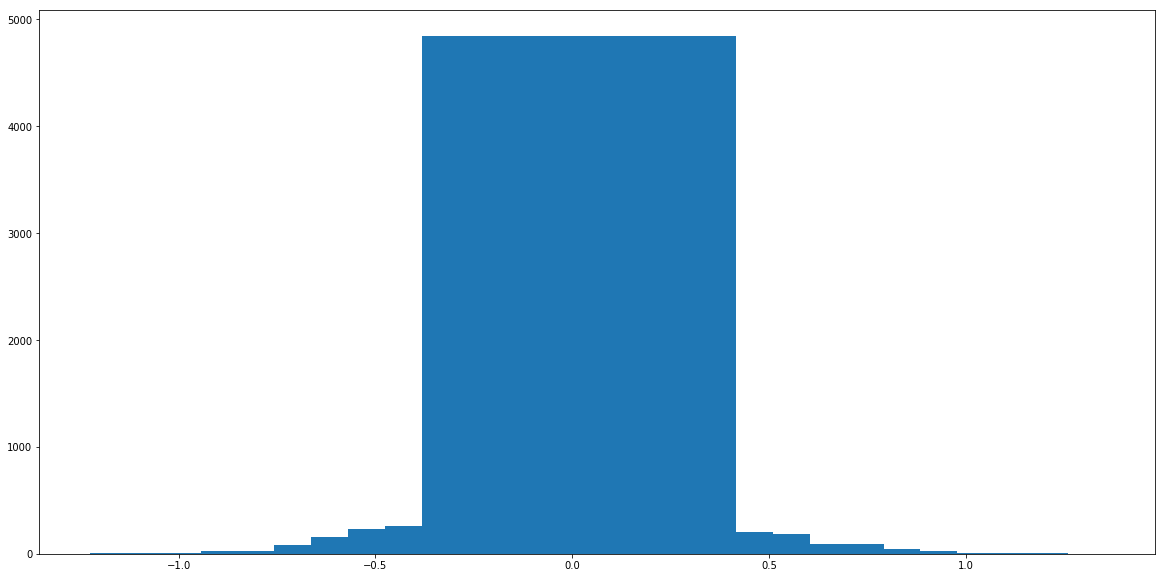

In [5]:
# Plot histogram distribution of the steering angles.
num_bins = 20
hist, bins = np.histogram(center_angles, num_bins)
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize = (20, 10))
plt.bar(center, hist)
plt.show()

In [6]:
# to increase amount of train samples we'll be using side camera images with correction for steer angles
left_angles  = []
right_angles = []

# we'll correct side cameras with constant |0.25| angle
for angle in center_angles:
    left_angles.append(angle + 0.25)
    right_angles.append(angle - 0.25)

In [7]:
all_imgs = left_imgs + center_imgs + right_imgs
all_angles = left_angles + center_angles + right_angles

In [8]:
inv_imgs = []
inv_angles = []

# Let's make even more training data by inverting images and angles by vertical axis
for ind, img in enumerate(all_imgs):
    inv_imgs.append(cv2.flip(img, 1))
    inv_angles.append(-all_angles[ind])

imgs = all_imgs + inv_imgs
angles = all_angles + inv_angles
print("All images size: ", str(len(imgs)))

All images size:  37812


In [20]:
def preprocess_image(img):
    new_img = img[50:140,:,:]
    new_img = cv2.resize(new_img,(64, 64), interpolation=cv2.INTER_AREA)
    new_img = new_img / 255.0 - 0.5
    return new_img

-0.25


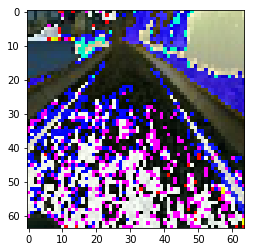

In [23]:
ind = random.randint(0,len(imgs))
angle = angles[ind]
img = imgs[ind]
print(angle)
plt.imshow(preprocess_image(img))

In [24]:
processed_imgs = []
for img in imgs:
    processed_imgs.append(preprocess_image(img))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(np.array(processed_imgs), np.array(angles))
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (28359, 64, 64, 3)
X_test shape:  (9453, 64, 64, 3)
y_train shape:  (28359,)
y_test shape:  (9453,)


In [31]:
SEPARABLE = False
BATCH_NORM = False
ACTIVATION = 'relu'
DROPOUT = True
IMG_SIZE = X_train.shape[1:]

In [32]:
def conv(x, depth, **args):
    convolution = SEPARABLE and K.layers.SeparableConv2D or K.layers.Conv2D
    x = convolution(depth, 3, padding='same', activation=ACTIVATION, **args)(x)
    if BATCH_NORM:
        x = K.layers.normalization.BatchNormalization()(x)
    return x

def max_pool(x):
    x = K.layers.MaxPool2D(strides=2)(x)
    if DROPOUT:
        x = K.layers.Dropout(0.25)(x)
    return x

def dense(x, width, **args):
    if not args.get('activation'):
        args['activation'] = ACTIVATION
    x = K.layers.Dense(width, **args)(x)
    if args['activation'] != 'linear':
        if BATCH_NORM:
            x = K.layers.normalization.BatchNormalization()(x)
        if DROPOUT:
            x = K.layers.Dropout(0.5)(x)
    return x

def unit(x, depth, count=2):
    for _ in range(count):
        x = conv(x, depth)
    return x

def create_model(input_shape):
    inputs = K.layers.Input(shape=input_shape)
    x = K.layers.Conv2D(32, 7, activation=ACTIVATION, strides=(2,2))(inputs)
    x = unit(x, 64)
    x = max_pool(x)
    x = unit(x, 128)
    x = max_pool(x)
    x = unit(x, 256)
    x = max_pool(x)
    x = K.layers.Flatten()(x)
    
    logits = K.layers.Dense(1)(x)

    return K.models.Model(inputs=inputs, outputs=logits)

In [33]:
K.backend.clear_session()

BATCH_SIZE = 128
EPOCHS = 100

model = create_model(IMG_SHAPE)
print(model.summary())
opt = K.optimizers.Adam(0.0001)
model.compile(loss='mse', optimizer=opt)

callbacks = [
    K.callbacks.EarlyStopping(monitor='val_loss',
                              patience=2),
    K.callbacks.ReduceLROnPlateau(factor=0.25, verbose=1, monitor='val_loss',
                                                          patience=2),
    K.callbacks.ModelCheckpoint('/home/saint/experiments/sdcnd/model.h5',
                                              save_best_only=True,
                                              monitor='val_loss')
]

from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
train_gen.fit(X_train)
test_gen.fit(X_test)
    
model.fit_generator(train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=(len(y_train)/BATCH_SIZE + 1),
                    epochs=EPOCHS,
                    validation_data=test_gen.flow(X_test, y_test, batch_size=BATCH_SIZE),
                    validation_steps=10,
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4736      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
__________

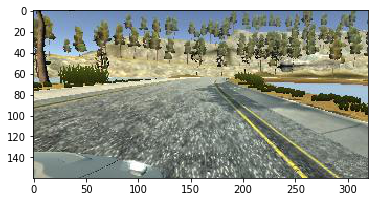

In [34]:
plt.imshow(right_imgs[3344])

In [35]:
print(model.predict(preprocess_image(right_imgs[3344])[None, :, :, :]))
print(right_angles[3344])

[[-0.23245203]]
-0.25
